In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as mtick

import argparse
import psycopg2


In [3]:
# parse argcall 
# parser = argparse.ArgumentParser(description='Query Google BigQuery for DSP data, send to specified recipients')
# parser.add_argument('-u','--username', help='username used to login to Olympus/Atlas')
# parser.add_argument('-p','--password', help='password used to login to Olympus/Atlas')
# parser.add_argument('-sd','--startdate', help='first date of the date range to analyze (YYYY-MM-DD)')
# parser.add_argument('-ed','--enddate', help='final date of the date range to analyze (YYYY-MM-DD)')

# args = parser.parse_args()

In [5]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')]

conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [6]:
start_dt = '2021-08-01'
end_dt = '2021-08-13'

In [27]:
query_slot_count = """
select
    t1.date
    , t1.siteid
    , t1.site_name
    , t1.isfdr
    , t1.c_name
    , t1.kind
    , t1.manufacturer
    , t1.model
    , sum(t1.device_count) as device_count
    , sum(t2.all_preloads) as all_preloads
    , sum(t2.house_preloads) as house_preloads
    , sum(t2.sponsored_preloads) as sponsored_preloads
    , sum(t2.house_campaign_ct) as house_campaign_ct
    , sum(t2.sponsored_campaign_ct) as sponsored_campaign_ct
from
(
    select
        f.c_name
        , f.isfdr
        , date(f.createdate at time zone 'utc' at time zone 'est') as date 
        , f.siteid
        , max(f.kind) kind
        , max(f.manufacturer) manufacturer
        , max(f.model) model
        , max(f.site_name) as site_name
        , count(distinct imei) as device_count
    from rawdata.dt_device_report f
    join rawdata.site s
        on f.siteid = s.site_id
    where
        date(f.createdate at time zone 'utc' at time zone 'est') >= date('{start_dt}')
        and date(f.createdate at time zone 'utc' at time zone 'est') <= date('{end_dt}')
        and kind = 'production'
        and f.rs_carrier_id in (1,2,11,13,28,44)
        and s.site_name not like '%RDNS%'
        and f.processtypeid = 1
    group by 1,2,3,4
) t1 
left join
(
    select
        date(ctp.tracking_time) as date
        , case 
            when p.partner_name like '%America Movil%' then 'AMXAPK'
            else replace(replace(substring(p.partner_name,3),' ',''),'&','')
        end as c_name
        , ctp.site_id
        , case when ctp.placement_id = 99 then 1 else 0 end as isfdr
        , count(distinct referrer) as all_preloads
        , count(distinct case when settled_price_per_download = 0 then referrer else NULL end) as house_preloads
        , count(distinct case when settled_price_per_download > 0 then referrer else NULL end) as sponsored_preloads
        , count(distinct case when settled_price_per_download = 0 then ctp.campaign_id else NULL end) as house_campaign_ct
        , count(distinct case when settled_price_per_download > 0 then ctp.campaign_id else NULL end) as sponsored_campaign_ct
    from rawdata.campaign_tracking_active_preload ctp
    join rawdata.site s
        on ctp.site_id = s.site_id
    join rawdata.partner_information p
        on s.partner_id = p.partner_id 
    where
        date(ctp.tracking_time) >= date('{start_dt}')
        and date(ctp.tracking_time) <= date('{end_dt}')
    group by 1,2,3,4
) t2 
    on t1.siteid = t2.site_id 
    and t1.date = t2.date 
    and t1.isfdr = t2.isfdr
    and t1.c_name = t2.c_name
group by 1,2,3,4,5,6,7,8
"""
cur_atlas.execute(query_slot_count.format(start_dt = start_dt, end_dt = end_dt))
df_slot_count = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

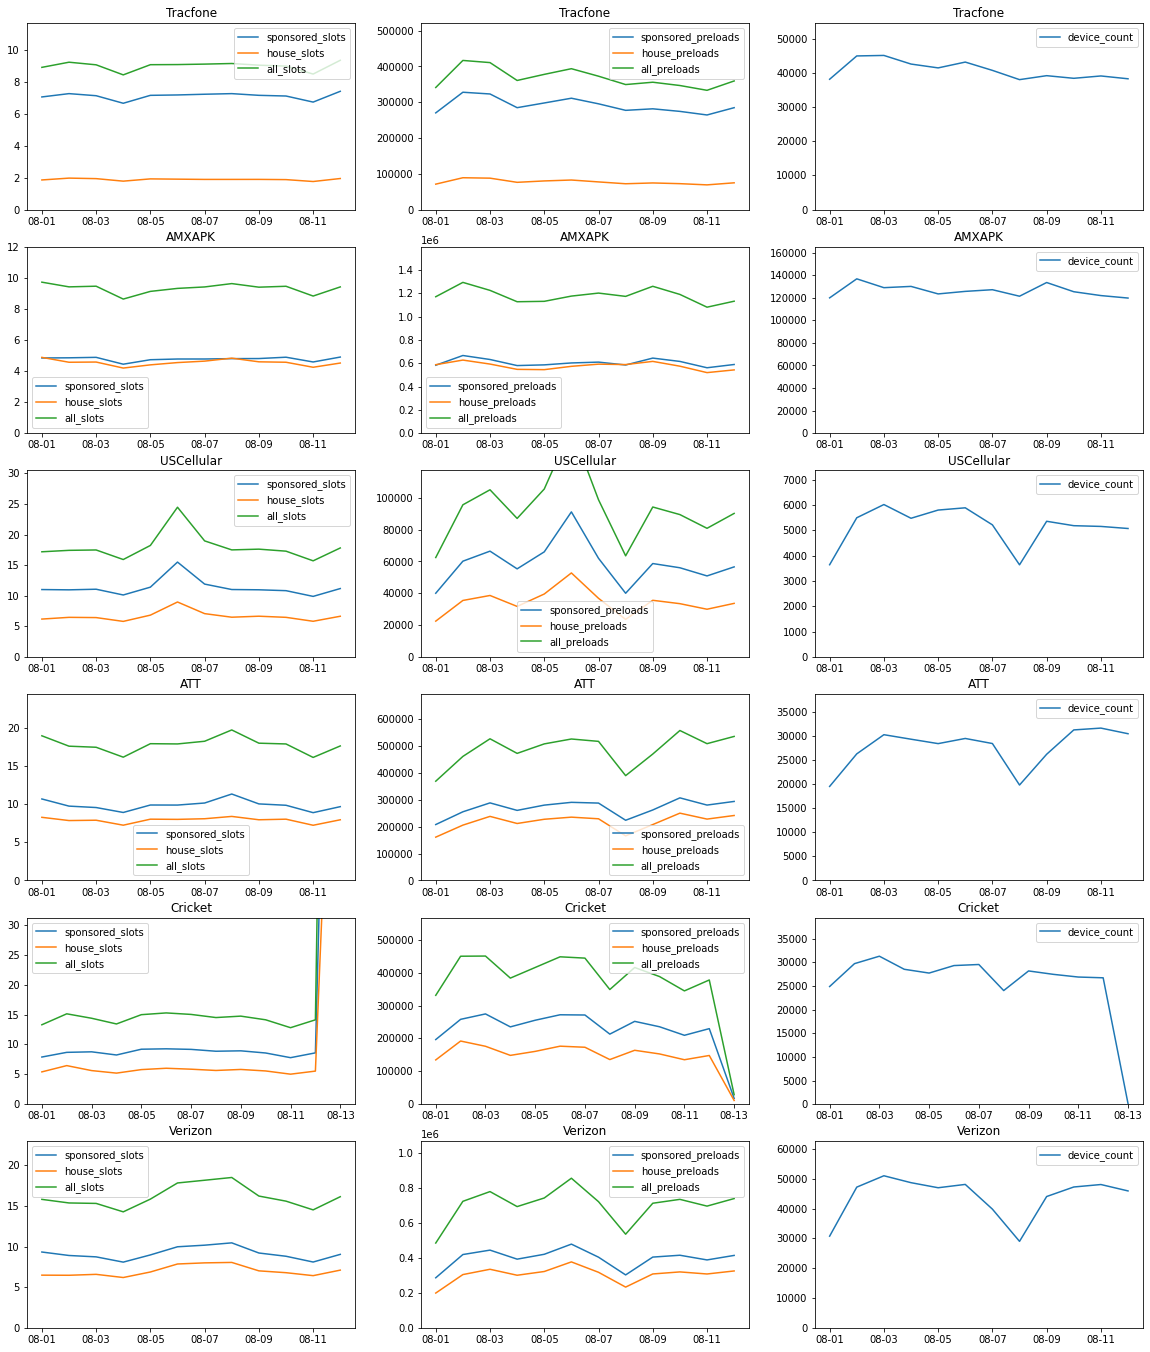

In [69]:
carriers = df_slot_count.c_name.unique().tolist()
by_date = df_slot_count.pivot_table(values = ['device_count','all_preloads','sponsored_preloads','house_preloads'], index = 'date', columns = 'c_name', aggfunc = np.sum)

fig, ax = plt.subplots(len(carriers),3, figsize = (20, 4*len(carriers)))
for n in range(len(carriers)):
    carrier = carriers[n]
    by_date[('sponsored_slots', carrier)] = by_date[('sponsored_preloads', carrier)]/by_date[('device_count', carrier)]
    by_date[('house_slots', carrier)] = by_date[('house_preloads', carrier)]/by_date[('device_count', carrier)]
    by_date[('all_slots', carrier)] = by_date[('all_preloads', carrier)]/by_date[('device_count', carrier)]

    ax[n,0].plot(by_date[[('sponsored_slots', carrier),('house_slots', carrier),('all_slots', carrier)]])
    ax[n,0].xaxis.set_major_formatter(mdate.DateFormatter('%m-%d'))
    ax[n,0].set_title(carrier)
    ax[n,0].legend(['sponsored_slots','house_slots','all_slots'])
    
    slots_mean = max([by_date[('sponsored_slots', carrier)].mean(),by_date[('house_slots', carrier)].mean()])
    slots_max = max([by_date[('sponsored_slots', carrier)].max(),by_date[('house_slots', carrier)].max()])
    
    if slots_max > 1.5*slots_mean:
        ymax = slots_mean*1.5
    else:
        ymax = ax[n,0].get_ylim()[1]*1.2
    ax[n,0].set_ylim(0,ymax)
    
    ax[n,1].plot(by_date[[('sponsored_preloads', carrier),('house_preloads', carrier),('all_preloads', carrier)]])
    ax[n,1].xaxis.set_major_formatter(mdate.DateFormatter('%m-%d'))
    ax[n,1].set_title(carrier)
    ax[n,1].legend(['sponsored_preloads','house_preloads','all_preloads'])
    
    preloads_mean = max([by_date[('sponsored_preloads', carrier)].mean(),by_date[('house_preloads', carrier)].mean()])
    preloads_max = max([by_date[('sponsored_preloads', carrier)].max(),by_date[('house_preloads', carrier)].max()])
    
    if preloads_max > 1.5*preloads_mean:
        ymax = preloads_mean*2
    else:
        ymax = ax[n,1].get_ylim()[1]*1.2
    ax[n,1].set_ylim(0,ymax)
    
    ax[n,2].plot(by_date[[('device_count', carrier)]])
    ax[n,2].xaxis.set_major_formatter(mdate.DateFormatter('%m-%d'))
    ax[n,2].set_title(carrier)
    ax[n,2].legend(['device_count'])
    
    device_count_mean = by_date[('device_count', carrier)].mean()
    device_count_max = by_date[('device_count', carrier)].max()
    
    if device_count_max > 1.5*device_count_mean:
        ymax = device_count_mean*2
    else:
        ymax = ax[n,2].get_ylim()[1]*1.2
    ax[n,2].set_ylim(0,ymax)


In [75]:
cols = by_date.columns.sortlevel([1,0])
cols

(MultiIndex([(      'all_preloads',     'AMXAPK'),
             (      'device_count',     'AMXAPK'),
             (    'house_preloads',     'AMXAPK'),
             ('sponsored_preloads',     'AMXAPK'),
             (   'sponsored_slots',     'AMXAPK'),
             (       'house_slots',     'AMXAPK'),
             (         'all_slots',     'AMXAPK'),
             (      'all_preloads',        'ATT'),
             (      'device_count',        'ATT'),
             (    'house_preloads',        'ATT'),
             ('sponsored_preloads',        'ATT'),
             (   'sponsored_slots',        'ATT'),
             (       'house_slots',        'ATT'),
             (         'all_slots',        'ATT'),
             (      'all_preloads',    'Cricket'),
             (      'device_count',    'Cricket'),
             (    'house_preloads',    'Cricket'),
             ('sponsored_preloads',    'Cricket'),
             (   'sponsored_slots',    'Cricket'),
             (       'house_slo

In [14]:
atlas_campaign_byday['date'] = pd.to_datetime(atlas_campaign_byday.date)
atlas_campaign_byday.groupby('date')['cost','spend'].sum()

<ipython-input-14-cf52a968691d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  atlas_campaign_byday.groupby('date')['cost','spend'].sum()


cost      spend
date                            
2021-08-01  240031.15  197937.02
2021-08-02  242570.77  194763.89
2021-08-03  238494.52  179631.96
2021-08-04  217931.92  166448.61
2021-08-05  215212.61  161613.56
2021-08-06  203927.41  155496.28
2021-08-07  207580.86  155865.30
2021-08-08  212642.50  160119.82
2021-08-09  216866.19  152492.16
2021-08-10  239516.91  150545.42
2021-08-11  218338.93  138540.55
2021-08-12  202002.03  128224.59

<ipython-input-33-8d9f3d8023b7>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax.plot(atlas_campaign_byday.groupby('date')['cost','spend'].sum())
<ipython-input-33-8d9f3d8023b7>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


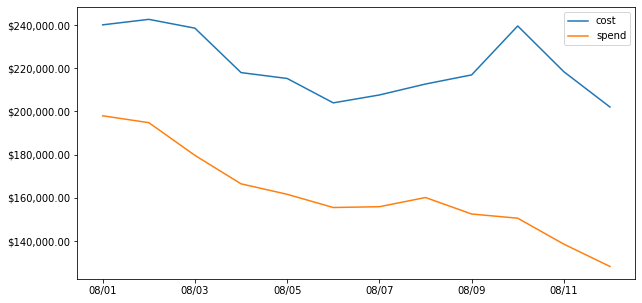

In [33]:
fig, ax = plt.subplots(figsize = (10,5))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax.plot(atlas_campaign_byday.groupby('date')['cost','spend'].sum())
ax.legend(['cost','spend'])
fig.savefig(f'files/total_spend_cost_{start_dt}_{end_dt}.png')
fig.show()
                             

In [34]:
writer = pd.ExcelWriter(f'slot_analysis_{start_dt}_{end_dt}.xlsx', engine = 'xlsxwriter')
atlas_campaign_byday.groupby('date')['cost','spend'].sum().to_excel(writer, sheet_name = 'agg_spend_cost_byday')
writer.sheets['agg_spend_cost_byday'].insert_image('E2',f'files/total_spend_cost_{start_dt}_{end_dt}.png')
writer.save()

<ipython-input-34-6262151f5e67>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  atlas_campaign_byday.groupby('date')['cost','spend'].sum().to_excel(writer, sheet_name = 'agg_spend_cost_byday')
